<a href="https://colab.research.google.com/github/Chimata-Bhavya/DataAnalytics/blob/main/SentimentStockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stacked LSTM

In [18]:
pip install keras

In [19]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
file_path = r'/content/drive/MyDrive/stock_tweets.csv'
all_tweets = pd.read_csv(file_path)

In [22]:
file_path = r'/content/drive/MyDrive/stock_yfinance_data.csv'
all_stocks = pd.read_csv(file_path)

In [23]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [24]:
stock_name = 'AMZN'
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(4089, 4)


,Date,Tweet,Stock Name,Company Name
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc."
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc."
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc."
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc."
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc."


In [25]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",,,,
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",,,,
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",,,,
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",,,,
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",,,,


In [26]:
%%time
import nltk
nltk.download('vader_lexicon')


sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.iterrows():
    try:
        sentence_i = unicodedata.normalize('NFKD', row['Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print(sent_df.loc[indx, 'Tweet'])
        break

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


CPU times: user 3.58 s, sys: 7.86 ms, total: 3.59 s
Wall time: 4.29 s


In [27]:
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",-0.0772,0.084,0.841,0.075
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",0.25,0.158,0.684,0.158
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",-0.3182,0.164,0.728,0.108
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",0.2382,0.065,0.851,0.083
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",0.7783,0.0,0.799,0.201


In [28]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

In [29]:
sent_df.head()

,Date,Tweet,sentiment_score
48351,2022-09-29,A group of lawmakers led by Sen. Elizabeth War...,-0.0772
48352,2022-09-29,$NIO just because I'm down money doesn't mean ...,0.25
48353,2022-09-29,Today’s drop in $SPX is a perfect example of w...,-0.3182
48354,2022-09-29,Druckenmiller owned $CVNA this year \nMunger b...,0.2382
48355,2022-09-29,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,0.7783


In [30]:
# Group by 'Date' and calculate the mean of 'sentiment_score'
# sent_df['sentiment_score'] = pd.to_numeric(sent_df['sentiment_score'])
twitter_df = sent_df.groupby('Date').agg({
    'sentiment_score': 'mean'
}).reset_index()
twitter_df.head()

,Date,sentiment_score
0,2021-09-30,0.24648
1,2021-10-01,0.359338
2,2021-10-02,-0.0007
3,2021-10-03,0.8344
4,2021-10-04,0.25865


In [31]:
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [32]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [33]:
# Merge with stock price data
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
twitter_df['Date'] = pd.to_datetime(twitter_df['Date']).dt.date
stock_df['Date'] = pd.to_datetime(stock_df['Date']).dt.date

final_df = stock_df.merge(twitter_df, how="left", on="Date", suffixes=('', '_2')).drop(columns=['Stock Name'])
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
0,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.24648
1,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.359338
2,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.25865
3,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.0455
4,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.1943


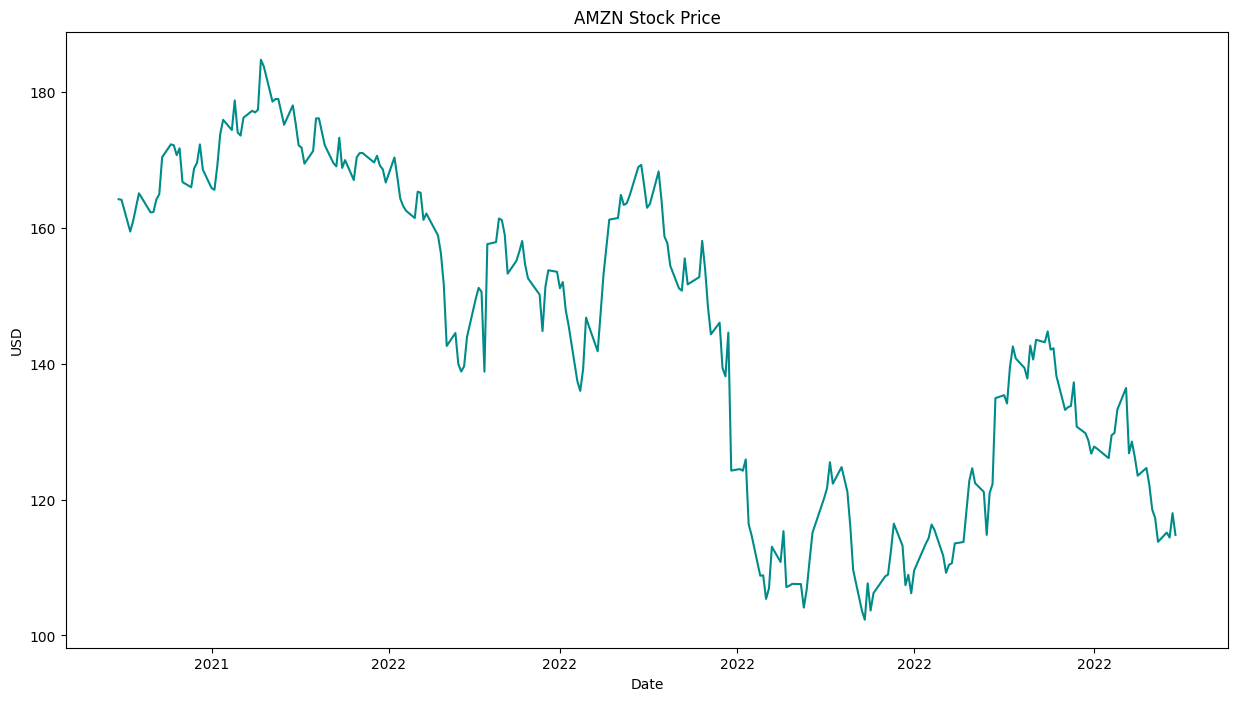

In [34]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [35]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [36]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [37]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [38]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [39]:
dataset = final_df.iloc[20:,:].reset_index(drop=True)
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 7)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [40]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from joblib import load

# Load scalers
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))


In [47]:
def build_stacked_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(1024, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [48]:
def train_model(X_train, y_train, epochs):
    model = build_stacked_lstm_model((X_train.shape[1], X_train.shape[2]))
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=1)
    return model, history


In [49]:
def plot_results(Real_price, Predicted_price, index_train):
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("Training Results", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Train RMSE: ', RMSE)


In [50]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Test Data Prediction for {stock_name}", fontsize=20)
    plt.show()


Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 593ms/step - loss: 0.2337 - val_loss: 0.0514
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 603ms/step - loss: 0.0476 - val_loss: 0.0400
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 508ms/step - loss: 0.0392 - val_loss: 0.0401
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 435ms/step - loss: 0.0372 - val_loss: 0.0377
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - loss: 0.0346 - val_loss: 0.0217
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - loss: 0.0471 - val_loss: 0.0379
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 426ms/step - loss: 0.0326 - val_loss: 0.0429
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 426ms/step - loss: 0.0322 - val_loss: 0.0241
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 614ms/step - loss: 0.0430 - val_loss: 0.0296
Epoch 10/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 454ms/step - loss: 0.0299 - val_loss: 0.0434
Epoch 11/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 439ms/step - loss: 0.0270 - val_loss: 0.0325
Epoch 12/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 613ms/step - loss: 0.0

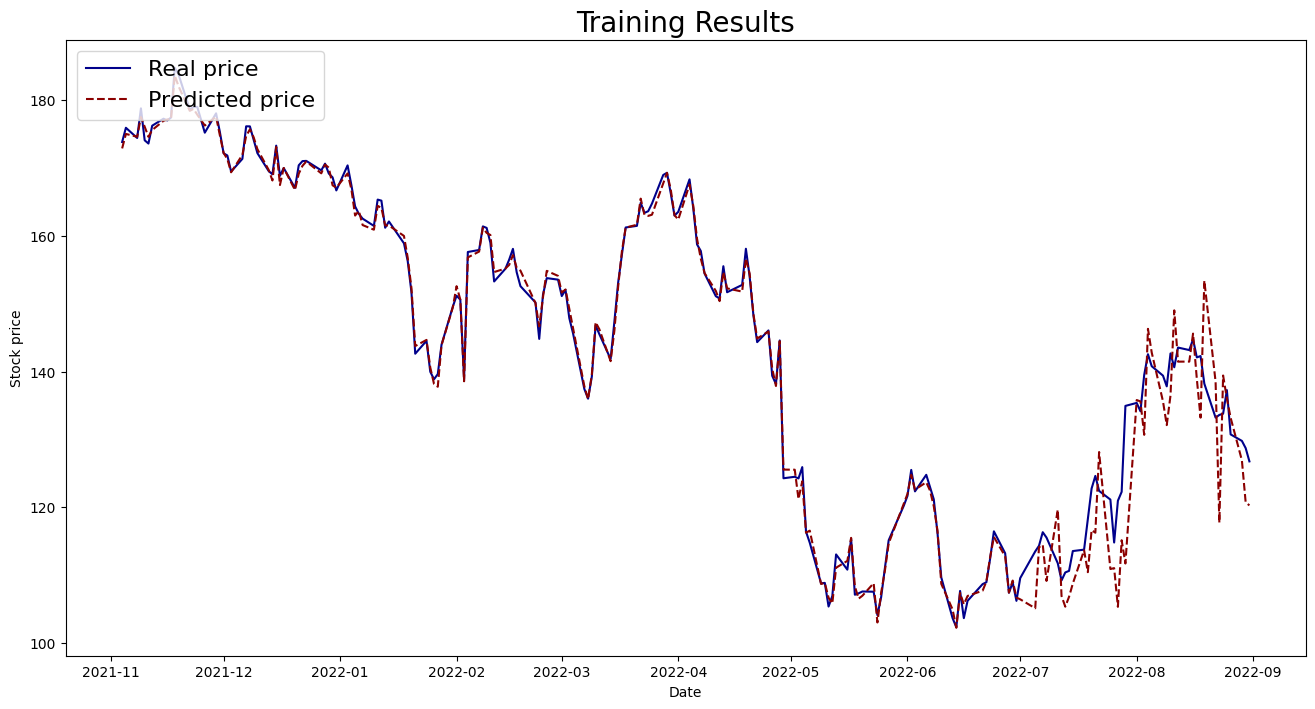

Train RMSE:  3.515982399059556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Test RMSE:  8.039801275303544


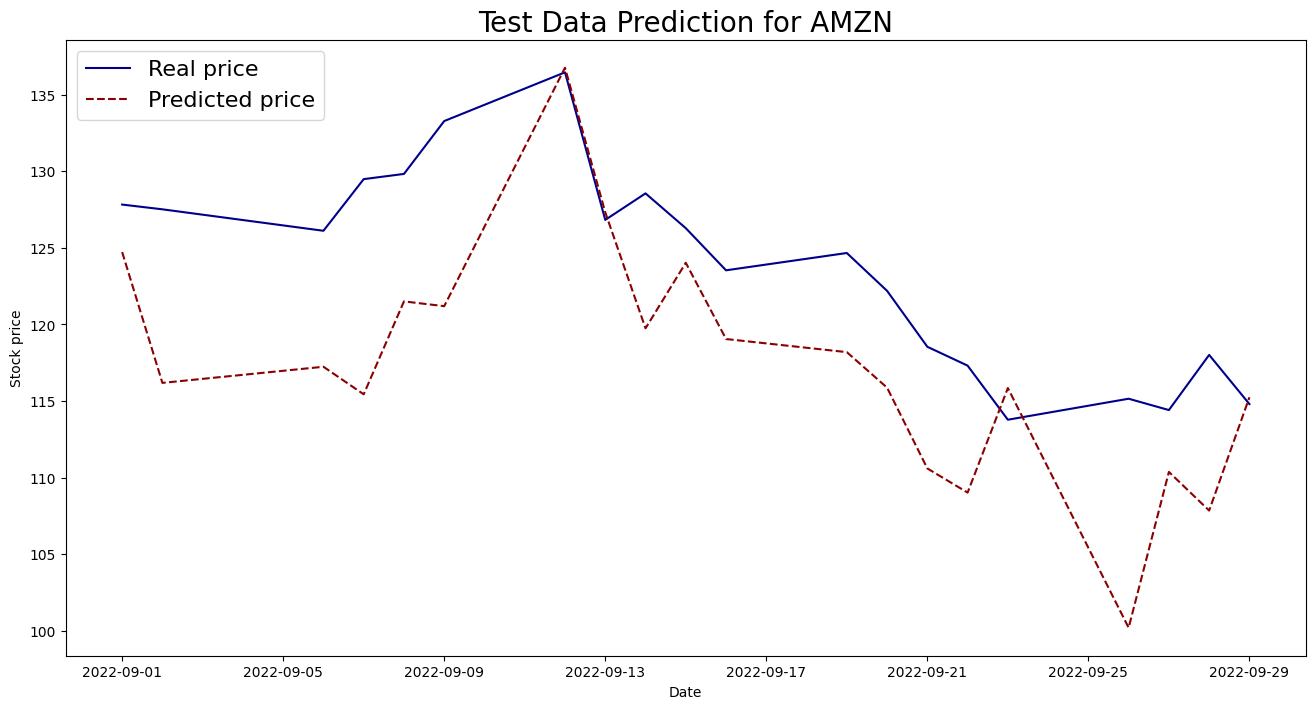

In [51]:
learning_rate = 5e-4
epochs = 500

# Assuming X_train, y_train, X_test, y_test, index_train, index_test, output_dim, and stock_name are defined
model, history = train_model(X_train, y_train, epochs)

# Predict on training data
train_predictions = model.predict(X_train)
plot_results(y_train, train_predictions, index_train)

# Predict on test data
test_predictions = model.predict(X_test)
plot_test_data(y_test, test_predictions, index_test)


In [61]:
import numpy as np

# Assuming test_predictions and y_test are numpy arrays
# Convert them to numpy arrays if they aren't already
test_predictions = np.array(test_predictions)
y_test = np.array(y_test)

# Compute squared differences
squared_diffs = (test_predictions - y_test) ** 2

# Compute the mean squared difference
mean_squared_diff = np.mean(squared_diffs)

# Compute RMSE
rmse = np.sqrt(mean_squared_diff)

print(f'RMSE: {rmse}')


RMSE: 0.19492080244770227


# TF-IDF, Technical Indicators and GAN Model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as stat
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = r'/content/drive/MyDrive/stock_tweets.csv'
train = pd.read_csv(file_path)
train.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [ ]:
file_path = r'/content/drive/MyDrive/stock_tweets.csv'
dataset = pd.read_csv(file_path)
dataset.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [ ]:
train = train[train['Stock Name'] == 'AMZN']

In [ ]:
dataset = dataset[dataset['Stock Name'] == 'AMZN']

Handling User Mentions and Hashtags:

In [ ]:
import re

# Define functions to extract user mentions and hashtags
def extract_user_mentions(text):
    # Use regex to find user mentions (e.g., @username)
    user_mentions = re.findall(r'@(\w+)', text)
    return user_mentions

def extract_hashtags(text):
    # Use regex to find hashtags (e.g., #topic)
    hashtags = re.findall(r'#(\w+)', text)
    return hashtags

# Apply the functions to the 'body' column
train['user_mentions'] = train['Tweet'].apply(extract_user_mentions)
train['hashtags'] = train['Tweet'].apply(extract_hashtags)

In [ ]:
train.head()

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
48351,2022-09-29 22:40:47+00:00,A group of lawmakers led by Sen. Elizabeth War...,AMZN,"Amazon.com, Inc.",[],[]
48352,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,AMZN,"Amazon.com, Inc.",[],[]
48353,2022-09-29 18:34:51+00:00,Today’s drop in $SPX is a perfect example of w...,AMZN,"Amazon.com, Inc.",[],[]
48354,2022-09-29 15:57:59+00:00,Druckenmiller owned $CVNA this year \nMunger b...,AMZN,"Amazon.com, Inc.",[],[]
48355,2022-09-29 15:10:30+00:00,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,AMZN,"Amazon.com, Inc.",[],[]


Lower Case:

In [ ]:
train['Tweet'] = train['Tweet'].str.lower()
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4089 entries, 48351 to 52439
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           4089 non-null   object
 1   Tweet          4089 non-null   object
 2   Stock Name     4089 non-null   object
 3   Company Name   4089 non-null   object
 4   user_mentions  4089 non-null   object
 5   hashtags       4089 non-null   object
dtypes: object(6)
memory usage: 352.7+ KB


In [ ]:
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
48619,2022-08-20 21:00:01+00:00,ray dalio's bridgewater associates raised thei...,AMZN,"Amazon.com, Inc.",[],[]
51948,2021-11-24 16:54:47+00:00,great bloomberg article today on $amzn's suppl...,AMZN,"Amazon.com, Inc.",[],[]
51324,2022-02-01 01:15:01+00:00,trade plan for tuesday ✅\n\n$spx strong move a...,AMZN,"Amazon.com, Inc.",[],[]
50993,2022-02-04 12:14:59+00:00,"so, $floki flipped $amzn on @stocktwits eh...\...",AMZN,"Amazon.com, Inc.",[Stocktwits],[FLOKI]
52171,2021-10-31 01:14:50+00:00,free #options swings ideas 🤯\n\n$amzn calls &...,AMZN,"Amazon.com, Inc.",[],[Options]
52104,2021-11-07 23:03:04+00:00,$abnb - above 200 - swing trade idea 💡 - dec ...,AMZN,"Amazon.com, Inc.",[],[]
52319,2021-10-21 04:18:19+00:00,eth $10k is as lame a price target as amzn $100,AMZN,"Amazon.com, Inc.",[],[]
49598,2022-05-22 15:34:47+00:00,important dates:\n\n$amzn stock split will be ...,AMZN,"Amazon.com, Inc.",[],[]
51163,2022-02-03 21:05:15+00:00,"sold the $3,200 price on my $amzn shares. took...",AMZN,"Amazon.com, Inc.",[],[]
51041,2022-02-04 00:17:41+00:00,"#es_f \n\n""being able to adapt your game when ...",AMZN,"Amazon.com, Inc.",[],"[ES_F, orderflow, volumeprofile, marketprofile..."


Removing punctuations, special characters, URLs:

In [ ]:
# Define a function to remove punctuation from a text string
def remove_punctuation(text):
    # Use regex to remove all non-alphanumeric characters (including punctuation)
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Apply the function to the 'text' column
train['Tweet'] = train['Tweet'].apply(remove_punctuation)

train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
52204,2021-10-29 02:54:53+00:00,the combined revenue of the 4 largest us compa...,AMZN,"Amazon.com, Inc.",[],[]
50409,2022-03-31 12:11:00+00:00,incredible chart from amat highlighting the ma...,AMZN,"Amazon.com, Inc.",[],[]
51752,2021-12-23 16:51:47+00:00,god is good merry christmas all done for the d...,AMZN,"Amazon.com, Inc.",[],[]
50595,2022-03-09 22:09:32+00:00,i am intrigued by timing of this amzn split ne...,AMZN,"Amazon.com, Inc.",[],[]
52201,2021-10-29 05:22:10+00:00,it wont take nio this long to reach a 1 trilli...,AMZN,"Amazon.com, Inc.",[],[]
51631,2022-01-03 23:22:28+00:00,which of these would you choose to hold for 20...,AMZN,"Amazon.com, Inc.",[],[]
49127,2022-07-10 13:04:14+00:00,to put into perspective how much trouble amzn ...,AMZN,"Amazon.com, Inc.",[],[]
51116,2022-02-03 21:28:09+00:00,lol everyone went from i bought puts on amzn ...,AMZN,"Amazon.com, Inc.",[],[]
49347,2022-06-09 03:52:53+00:00,charts posted for tonight \n\nreviewed\nspy\nq...,AMZN,"Amazon.com, Inc.",[],[]
50256,2022-04-17 15:33:49+00:00,everyone seems to hate amzns covid capex ramp ...,AMZN,"Amazon.com, Inc.",[],[]


In [ ]:
def remove_special_characters(text):
    # Use regex to remove all non-alphanumeric characters (including special characters)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

train['Tweet'] = train['Tweet'].apply(remove_special_characters)
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
49403,2022-06-06 11:33:53+00:00,amzn mkm partners adjusts target price to 180 ...,AMZN,"Amazon.com, Inc.",[],[]
51122,2022-02-03 21:23:32+00:00,amzn ive been in the game long enough to know ...,AMZN,"Amazon.com, Inc.",[],[]
52250,2021-10-28 12:08:42+00:00,elon musk and jeff bezos are now worth almost ...,AMZN,"Amazon.com, Inc.",[],[]
49661,2022-05-17 21:43:57+00:00,anyone ever seen amazons invested capital spli...,AMZN,"Amazon.com, Inc.",[],[]
50376,2022-04-04 18:52:50+00:00,yall have lost your fucking minds if you think...,AMZN,"Amazon.com, Inc.",[],[]
51477,2022-01-21 15:55:07+00:00,first ever milli day\n\nholy fuck\n\nthanks am...,AMZN,"Amazon.com, Inc.",[],[]
50849,2022-02-11 18:37:36+00:00,loaded some more goog amzn nflx and other tech...,AMZN,"Amazon.com, Inc.",[],[]
51589,2022-01-08 01:55:18+00:00,amzn 3250 \n\nhard to see it not being at leas...,AMZN,"Amazon.com, Inc.",[],[]
52012,2021-11-18 16:54:30+00:00,you do not need 10 trades a day\nyesterday was...,AMZN,"Amazon.com, Inc.",[],[]
51057,2022-02-03 22:49:15+00:00,amzn raising prime membership 20yearmember ove...,AMZN,"Amazon.com, Inc.",[],[]


In [ ]:
def remove_urls(text):
    # Use regex to remove URLs from the text
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

train['Tweet'] = train['Tweet'].apply(remove_urls)
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags
49718,2022-05-12 13:00:03+00:00,premarket plan \n\nspx if it fails at 3875 we ...,AMZN,"Amazon.com, Inc.",[],[]
50239,2022-04-19 20:36:46+00:00,lot of guys think nflx cheap at 260\n\nits not...,AMZN,"Amazon.com, Inc.",[],[]
50735,2022-02-24 23:40:41+00:00,my success with amzn today therealnasa00 taug...,AMZN,"Amazon.com, Inc.",[TheRealNasa00],[]
48946,2022-07-26 19:42:51+00:00,amzn is down over 5 today,AMZN,"Amazon.com, Inc.",[],[]
51334,2022-01-31 11:20:14+00:00,looking for value stocks\nbuy these\nmmm\nko\n...,AMZN,"Amazon.com, Inc.",[],[]
48472,2022-09-12 14:14:35+00:00,amzn will spend 15b on streaming content in 22...,AMZN,"Amazon.com, Inc.",[],[]
48541,2022-08-30 20:46:53+00:00,negative earnings forecast revisions for megac...,AMZN,"Amazon.com, Inc.",[],[]
49914,2022-04-29 21:01:12+00:00,amzn down 401 today or 14 is now in a stage 4 ...,AMZN,"Amazon.com, Inc.",[],[]
49567,2022-05-24 23:35:44+00:00,heres the intro of todays marketoutlook video ...,AMZN,"Amazon.com, Inc.",[MarketScholars],[MarketOutlook]
49338,2022-06-10 14:00:34+00:00,amzn getting crushed after the split wow,AMZN,"Amazon.com, Inc.",[],[]


Tokenization

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize
train['tweet_tokens'] = train['Tweet'].apply(word_tokenize)
train.sample(5)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens
51089,2022-02-03 21:52:21+00:00,couple nuggets of truth\n1 megacap stocks do n...,AMZN,"Amazon.com, Inc.",[],[],"[couple, nuggets, of, truth, 1, megacap, stock..."
48505,2022-09-05 18:21:16+00:00,throwback to 2013 when ring then named doorbot...,AMZN,"Amazon.com, Inc.",[],[],"[throwback, to, 2013, when, ring, then, named,..."
48578,2022-08-24 23:04:36+00:00,remember when amazon was taking over the teleh...,AMZN,"Amazon.com, Inc.",[],[],"[remember, when, amazon, was, taking, over, th..."
48360,2022-09-29 00:14:54+00:00,92922 options trading watchlist \n\namzn 11411...,AMZN,"Amazon.com, Inc.",[],"[optionstrading, stocks]","[92922, options, trading, watchlist, amzn, 114..."
49352,2022-06-08 20:04:38+00:00,leaving big tech banking for fintech \n\namz...,AMZN,"Amazon.com, Inc.",[],[Stripe],"[leaving, big, tech, banking, for, fintech, am..."


Removing gibberish, stop words

In [ ]:
from nltk.corpus import words

nltk.download('words')
english_words = set(words.words())

def remove_gibberish(tokens):
    cleaned_tokens = [token for token in tokens if token.lower() in english_words]
    return cleaned_tokens

train['tweet_tokens'] = train['tweet_tokens'].apply(remove_gibberish)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
nltk.download('all')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

train['tweet_tokens'] = train['tweet_tokens'].apply(remove_stopwords)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root

In [ ]:
train.sample(5)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens
51929,2021-11-28 04:31:09+00:00,amzn expecting strong ecomm holiday against to...,AMZN,"Amazon.com, Inc.",[],[],"[strong, holiday, tough, return, supply, labor..."
49195,2022-07-01 12:26:04+00:00,happy canadaday traders \n\nstickynote doesnt...,AMZN,"Amazon.com, Inc.",[],"[CanadaDay, Stickynote]","[happy, doesnt, sleep, stick, name, mu, hit, s..."
52425,2021-10-02 14:24:45+00:00,day by day the pattern is becoming more cleart...,AMZN,"Amazon.com, Inc.",[],[],"[day, day, pattern, becoming, classic, accumul..."
51254,2022-02-03 12:11:24+00:00,if pypl can lose 25 so can fb so can amzn today,AMZN,"Amazon.com, Inc.",[],[],"[lose, today]"
50714,2022-02-28 14:14:37+00:00,tdoc shares are up gt10 after teaming up w the...,AMZN,"Amazon.com, Inc.",[],[],"[teaming, w, supposed, killer, must, stock, goes]"


Lemmatization

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 57.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
def lemmatize_tokens(tokens):
    text = " ".join(tokens)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

In [ ]:
train['lemmatized_tweets'] = train['tweet_tokens'].apply(lemmatize_tokens)
train.sample(5)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets
48812,2022-07-29 20:05:26+00:00,amazon amzn shares finished july up 27 its big...,AMZN,"Amazon.com, Inc.",[],[],"[finished, biggest, monthly, gain, since]","[finish, big, monthly, gain, since]"
50178,2022-04-23 15:00:17+00:00,what is spy ready to do here are we going to ...,AMZN,"Amazon.com, Inc.",[],[],"[spy, ready, going, clip, trend, line, mostly,...","[spy, ready, go, clip, trend, line, mostly, hi..."
50916,2022-02-06 19:40:04+00:00,amzn goldman revised forecast the next few years,AMZN,"Amazon.com, Inc.",[],[],"[forecast, next]","[forecast, next]"
52022,2021-11-17 17:09:44+00:00,amzn goldman top internet pick for 2022,AMZN,"Amazon.com, Inc.",[],[],"[top, pick]","[top, pick]"
51820,2021-12-13 20:42:23+00:00,amzn reiterated with outperform rating by cowe...,AMZN,"Amazon.com, Inc.",[],[],"[reiterated, outperform, rating, price, target...","[reiterate, outperform, rating, price, target,..."


N-Grams

In [ ]:
from nltk.util import ngrams

In [ ]:
n_gram_order = 2

def extract_ngrams(tokens, n):
    if len(tokens) >= n:
        return list(ngrams(tokens, n))
    else:
        return []

In [ ]:
train['bigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,bigrams
50120,2022-04-26 21:03:03+00:00,looks like a fun day sorry i missed it\n\ni di...,AMZN,"Amazon.com, Inc.",[],[],"[like, fun, day, sorry, close, call, open, tur...","[like, fun, day, sorry, close, call, open, tur...","[(like, fun), (fun, day), (day, sorry), (sorry..."
49883,2022-05-01 15:47:18+00:00,rolling over my 401k from previous employer th...,AMZN,"Amazon.com, Inc.",[],[],"[rolling, previous, employer, week, defensive,...","[roll, previous, employer, week, defensive, gr...","[(roll, previous), (previous, employer), (empl..."
50708,2022-03-02 00:31:55+00:00,rivn stock drops again a month later when amzn...,AMZN,"Amazon.com, Inc.",[],[],"[stock, month, later, deal, electric, trucks, ...","[stock, month, later, deal, electric, truck, d...","[(stock, month), (month, later), (later, deal)..."
49017,2022-07-22 12:26:31+00:00,good morning traders \n\nthanks for checking t...,AMZN,"Amazon.com, Inc.",[],[stickynote],"[good, morning, thanks, snap, feel, long, migh...","[good, morning, thank, snap, feel, long, might...","[(good, morning), (morning, thank), (thank, sn..."
51126,2022-02-03 21:22:28+00:00,wow wow wow \n\nwent bullish amzn at 2760 now ...,AMZN,"Amazon.com, Inc.",[],[],"[wow, wow, wow, went, bullish]","[wow, wow, wow, go, bullish]","[(wow, wow), (wow, wow), (wow, go), (go, bulli..."
50653,2022-03-08 20:11:39+00:00,amzn not accepting new aws customers in russia...,AMZN,"Amazon.com, Inc.",[],[],"[new, russia]","[new, russia]","[(new, russia)]"
48889,2022-07-28 20:06:28+00:00,amzn earnings just confirm that wmt is a flas...,AMZN,"Amazon.com, Inc.",[],[],"[earnings, confirm, flash, pan]","[earning, confirm, flash, pan]","[(earning, confirm), (confirm, flash), (flash,..."
48703,2022-08-10 12:20:40+00:00,walmart wmt is building a streaming service to...,AMZN,"Amazon.com, Inc.",[],[],"[building, streaming, service, take, prime, pe...","[build, streaming, service, take, prime, per, ...","[(build, streaming), (streaming, service), (se..."
50459,2022-03-24 21:13:16+00:00,nvda amzn amd 1d the double bottom beasts,AMZN,"Amazon.com, Inc.",[],[],"[double, bottom]","[double, bottom]","[(double, bottom)]"
51457,2022-01-21 21:55:36+00:00,amzn should have split instead to bring its pr...,AMZN,"Amazon.com, Inc.",[],[],"[split, instead, bring, price]","[split, instead, bring, price]","[(split, instead), (instead, bring), (bring, p..."


In [ ]:
n_gram_order = 3

def extract_ngrams(tokens, n):
    if len(tokens) >= n:
        return list(ngrams(tokens, n))
    else:
        return []

In [ ]:
train['trigrams'] = train['lemmatized_tweets'].apply(lambda x: extract_ngrams(x, n_gram_order))
train.head(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,bigrams,trigrams
48351,2022-09-29 22:40:47+00:00,a group of lawmakers led by sen elizabeth warr...,AMZN,"Amazon.com, Inc.",[],[],"[group, led, sen, warren, federal, trade, comm...","[group, lead, sen, warren, federal, trade, com...","[(group, lead), (lead, sen), (sen, warren), (w...","[(group, lead, sen), (lead, sen, warren), (sen..."
48352,2022-09-29 22:23:54+00:00,nio just because im down money doesnt mean thi...,AMZN,"Amazon.com, Inc.",[],[],"[money, doesnt, mean, bad, investment, whole, ...","[money, do, not, mean, bad, investment, whole,...","[(money, do), (do, not), (not, mean), (mean, b...","[(money, do, not), (do, not, mean), (not, mean..."
48353,2022-09-29 18:34:51+00:00,todays drop in spx is a perfect example of wha...,AMZN,"Amazon.com, Inc.",[],[],"[drop, perfect, example, turn, lower, finally,...","[drop, perfect, example, turn, lower, finally,...","[(drop, perfect), (perfect, example), (example...","[(drop, perfect, example), (perfect, example, ..."
48354,2022-09-29 15:57:59+00:00,druckenmiller owned cvna this year \nmunger bo...,AMZN,"Amazon.com, Inc.",[],[],"[year, bought, baba, margin, dean, valuation, ...","[year, buy, baba, margin, dean, valuation, met...","[(year, buy), (buy, baba), (baba, margin), (ma...","[(year, buy, baba), (buy, baba, margin), (baba..."
48355,2022-09-29 15:10:30+00:00,top 10 qqq holdings \n\nand credit rating\n\na...,AMZN,"Amazon.com, Inc.",[],[],"[top, credit, rating, meta, pep, cost, coming,...","[top, credit, rating, meta, pep, cost, come, l...","[(top, credit), (credit, rating), (rating, met...","[(top, credit, rating), (credit, rating, meta)..."
48356,2022-09-29 13:38:47+00:00,wage inflation profit margin \namzn\n,AMZN,"Amazon.com, Inc.",[],[],"[wage, inflation, profit, margin]","[wage, inflation, profit, margin]","[(wage, inflation), (inflation, profit), (prof...","[(wage, inflation, profit), (inflation, profit..."
48357,2022-09-29 13:04:39+00:00,amazon to loan over 150m to small businesses o...,AMZN,"Amazon.com, Inc.",[],[],"[loan, small, next]","[loan, small, next]","[(loan, small), (small, next)]","[(loan, small, next)]"
48358,2022-09-29 10:18:43+00:00,stocks i think entering intriguing levels to a...,AMZN,"Amazon.com, Inc.",[],[],"[stocks, think, entering, intriguing, add, sev...","[stock, think, enter, intriguing, add, several...","[(stock, think), (think, enter), (enter, intri...","[(stock, think, enter), (think, enter, intrigu..."
48359,2022-09-29 06:58:00+00:00,news\n\n boe buys bonds saves pensions\n mort...,AMZN,"Amazon.com, Inc.",[],[],"[news, mortgage, leave, politician, stock, ban...","[news, mortgage, leave, politician, stock, ban...","[(news, mortgage), (mortgage, leave), (leave, ...","[(news, mortgage, leave), (mortgage, leave, po..."
48360,2022-09-29 00:14:54+00:00,92922 options trading watchlist \n\namzn 11411...,AMZN,"Amazon.com, Inc.",[],"[optionstrading, stocks]","[trading, bearish, job, report, significant, c...","[trade, bearish, job, report, significant, cha...","[(trade, bearish), (bearish, job), (job, repor...","[(trade, bearish, job), (bearish, job, report)..."


TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
train['tfidf_text'] = train['lemmatized_tweets'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(train['tfidf_text'])
tfidf_features = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features)
tfidf_df.head()

,aa,aal,ability,able,abortion,absent,absolute,absolutely,absurd,abundance,...,yo,york,you,young,yoy,yr,zero,zipper,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
non_zero_count = np.count_nonzero(tfidf_df.values)
print("Number of non-zero values in tfidf_df:", non_zero_count)

Number of non-zero values in tfidf_df: 36447


In [ ]:
train.head(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,bigrams,trigrams,tfidf_text
48351,2022-09-29 22:40:47+00:00,a group of lawmakers led by sen elizabeth warr...,AMZN,"Amazon.com, Inc.",[],[],"[group, led, sen, warren, federal, trade, comm...","[group, lead, sen, warren, federal, trade, com...","[(group, lead), (lead, sen), (sen, warren), (w...","[(group, lead, sen), (lead, sen, warren), (sen...",group lead sen warren federal trade commission...
48352,2022-09-29 22:23:54+00:00,nio just because im down money doesnt mean thi...,AMZN,"Amazon.com, Inc.",[],[],"[money, doesnt, mean, bad, investment, whole, ...","[money, do, not, mean, bad, investment, whole,...","[(money, do), (do, not), (not, mean), (mean, b...","[(money, do, not), (do, not, mean), (not, mean...",money do not mean bad investment whole market ...
48353,2022-09-29 18:34:51+00:00,todays drop in spx is a perfect example of wha...,AMZN,"Amazon.com, Inc.",[],[],"[drop, perfect, example, turn, lower, finally,...","[drop, perfect, example, turn, lower, finally,...","[(drop, perfect), (perfect, example), (example...","[(drop, perfect, example), (perfect, example, ...",drop perfect example turn lower finally drop b...
48354,2022-09-29 15:57:59+00:00,druckenmiller owned cvna this year \nmunger bo...,AMZN,"Amazon.com, Inc.",[],[],"[year, bought, baba, margin, dean, valuation, ...","[year, buy, baba, margin, dean, valuation, met...","[(year, buy), (buy, baba), (baba, margin), (ma...","[(year, buy, baba), (buy, baba, margin), (baba...",year buy baba margin dean valuation meta year ...
48355,2022-09-29 15:10:30+00:00,top 10 qqq holdings \n\nand credit rating\n\na...,AMZN,"Amazon.com, Inc.",[],[],"[top, credit, rating, meta, pep, cost, coming,...","[top, credit, rating, meta, pep, cost, come, l...","[(top, credit), (credit, rating), (rating, met...","[(top, credit, rating), (credit, rating, meta)...",top credit rating meta pep cost come learn cre...
48356,2022-09-29 13:38:47+00:00,wage inflation profit margin \namzn\n,AMZN,"Amazon.com, Inc.",[],[],"[wage, inflation, profit, margin]","[wage, inflation, profit, margin]","[(wage, inflation), (inflation, profit), (prof...","[(wage, inflation, profit), (inflation, profit...",wage inflation profit margin
48357,2022-09-29 13:04:39+00:00,amazon to loan over 150m to small businesses o...,AMZN,"Amazon.com, Inc.",[],[],"[loan, small, next]","[loan, small, next]","[(loan, small), (small, next)]","[(loan, small, next)]",loan small next
48358,2022-09-29 10:18:43+00:00,stocks i think entering intriguing levels to a...,AMZN,"Amazon.com, Inc.",[],[],"[stocks, think, entering, intriguing, add, sev...","[stock, think, enter, intriguing, add, several...","[(stock, think), (think, enter), (enter, intri...","[(stock, think, enter), (think, enter, intrigu...",stock think enter intriguing add several alrea...
48359,2022-09-29 06:58:00+00:00,news\n\n boe buys bonds saves pensions\n mort...,AMZN,"Amazon.com, Inc.",[],[],"[news, mortgage, leave, politician, stock, ban...","[news, mortgage, leave, politician, stock, ban...","[(news, mortgage), (mortgage, leave), (leave, ...","[(news, mortgage, leave), (mortgage, leave, po...",news mortgage leave politician stock ban bill ...
48360,2022-09-29 00:14:54+00:00,92922 options trading watchlist \n\namzn 11411...,AMZN,"Amazon.com, Inc.",[],"[optionstrading, stocks]","[trading, bearish, job, report, significant, c...","[trade, bearish, job, report, significant, cha...","[(trade, bearish), (bearish, job), (job, repor...","[(trade, bearish, job), (bearish, job, report)...",trade bearish job report significant change st...


WordCloud

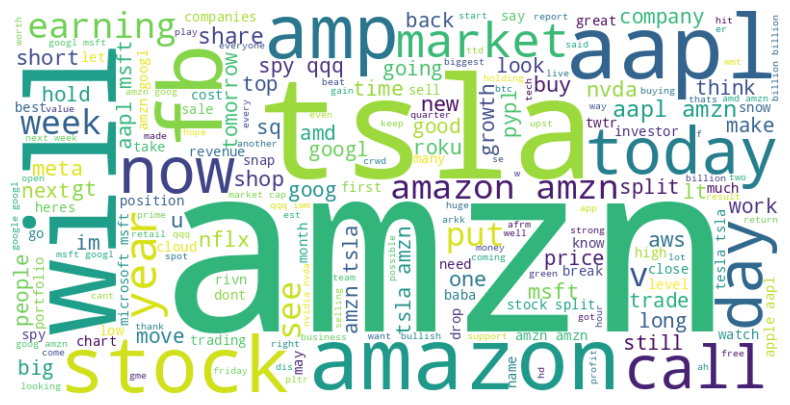

In [ ]:
#Unigram cloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'tweet' column contains the text data
text_data = ' '.join(train['Tweet'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

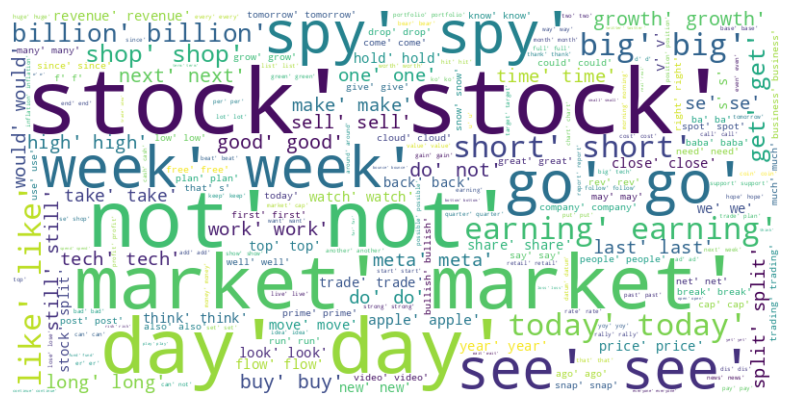

In [ ]:
bigram_text = ' '.join([' '.join(map(str, bigrams)) for bigrams in train['bigrams']])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bigram_text)

# Display the bigram word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#VADER Sentiment Analysis

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
def get_sentiment_scores(text):
    # Join the list of lemmatized words into a single string
    text = ' '.join(text)
    sentiment = analyzer.polarity_scores(text)
    return sentiment

train['sentiment_scores'] = train['lemmatized_tweets'].apply(get_sentiment_scores)
train['compound_score'] = train['sentiment_scores'].apply(lambda x: x['compound'])
train.sample(10)

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,bigrams,trigrams,tfidf_text,sentiment_scores,compound_score
49982,2022-04-29 01:42:01+00:00,tsla can explode money from aapl googl amzn ...,AMZN,"Amazon.com, Inc.",[],[],"[explode, money]","[explode, money]","[(explode, money)]",[],explode money,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
51657,2022-01-01 22:29:57+00:00,tracking stanley druckenmillers duquesne famil...,AMZN,"Amazon.com, Inc.",[],[],"[family, office, portfolio, update]","[family, office, portfolio, update]","[(family, office), (office, portfolio), (portf...","[(family, office, portfolio), (office, portfol...",family office portfolio update,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
50512,2022-03-17 00:58:34+00:00,quad witching for newcomers trendspider \n\nqu...,AMZN,"Amazon.com, Inc.",[TrendSpider],[],"[quad, witching, quad, witching, times, year, ...","[quad, witch, quad, witching, time, year, marc...","[(quad, witch), (witch, quad), (quad, witching...","[(quad, witch, quad), (witch, quad, witching),...",quad witch quad witching time year march june ...,"{'neg': 0.132, 'neu': 0.737, 'pos': 0.132, 'co...",0.0000
50398,2022-04-01 18:09:23+00:00,this tells you how serious this is for amzn i...,AMZN,"Amazon.com, Inc.",[],[],"[serious, dont, see, union]","[serious, do, not, see, union]","[(serious, do), (do, not), (not, see), (see, u...","[(serious, do, not), (do, not, see), (not, see...",serious do not see union,"{'neg': 0.245, 'neu': 0.755, 'pos': 0.0, 'comp...",-0.0772
51399,2022-01-26 11:59:09+00:00,enough fear was created by the institution th...,AMZN,"Amazon.com, Inc.",[],[bitcoin],"[enough, fear, institution, froze, nothing, re...","[enough, fear, institution, freeze, nothing, r...","[(enough, fear), (fear, institution), (institu...","[(enough, fear, institution), (fear, instituti...",enough fear institution freeze nothing respect...,"{'neg': 0.341, 'neu': 0.391, 'pos': 0.267, 'co...",-0.2815
52243,2021-10-28 19:04:45+00:00,16 bezos invested for couple of decades in bui...,AMZN,"Amazon.com, Inc.",[],[],"[couple, building, retail, infrastructure, wit...","[couple, build, retail, infrastructure, withou...","[(couple, build), (build, retail), (retail, in...","[(couple, build, retail), (build, retail, infr...",couple build retail infrastructure without sho...,"{'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'comp...",-0.2960
51628,2022-01-04 02:29:06+00:00,amzn had a big bounce and is starting to look ...,AMZN,"Amazon.com, Inc.",[],[],"[big, bounce, starting, look, bullish, big, br...","[big, bounce, start, look, bullish, big, break...","[(big, bounce), (bounce, start), (start, look)...","[(big, bounce, start), (bounce, start, look), ...",big bounce start look bullish big breakout cou...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
51156,2022-02-03 21:07:54+00:00,what that loud sound you ask\n\nthats the soun...,AMZN,"Amazon.com, Inc.",[],[],"[loud, sound, ask, thats, sound, bearish]","[loud, sound, ask, that, s, sound, bearish]","[(loud, sound), (sound, ask), (ask, that), (th...","[(loud, sound, ask), (sound, ask, that), (ask,...",loud sound ask that s sound bearish,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
52072,2021-11-10 22:02:00+00:00,afrm expansion of the amzn partnership is huge...,AMZN,"Amazon.com, Inc.",[],[],"[expansion, partnership, huge, thats, added, p...","[expansion, partnership, huge, that, s, add, p...","[(expansion, partnership), (partnership, huge)...","[(expansion, partnership, huge), (partnership,...",expansion partnership huge that s add put pers...,"{'neg': 0.0, 'neu': 0.777, 'pos': 0.223, 'comp...",0.3182
51837,2021-12-10 15:50:07+00:00,amzn down 100 from hod,AMZN,"Amazon.com, Inc.",[],[],[hod],[hod],[],[],hod,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


#Stock prediction

In [ ]:
# dataset.head()
train['tweets'] = dataset['Tweet']
train.head()

,Date,Tweet,Stock Name,Company Name,user_mentions,hashtags,tweet_tokens,lemmatized_tweets,bigrams,trigrams,tfidf_text,sentiment_scores,compound_score,tweets
48351,2022-09-29 22:40:47+00:00,a group of lawmakers led by sen elizabeth warr...,AMZN,"Amazon.com, Inc.",[],[],"[group, led, sen, warren, federal, trade, comm...","[group, lead, sen, warren, federal, trade, com...","[(group, lead), (lead, sen), (sen, warren), (w...","[(group, lead, sen), (lead, sen, warren), (sen...",group lead sen warren federal trade commission...,"{'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp...",-0.4019,A group of lawmakers led by Sen. Elizabeth War...
48352,2022-09-29 22:23:54+00:00,nio just because im down money doesnt mean thi...,AMZN,"Amazon.com, Inc.",[],[],"[money, doesnt, mean, bad, investment, whole, ...","[money, do, not, mean, bad, investment, whole,...","[(money, do), (do, not), (not, mean), (mean, b...","[(money, do, not), (do, not, mean), (not, mean...",money do not mean bad investment whole market ...,"{'neg': 0.069, 'neu': 0.491, 'pos': 0.44, 'com...",0.8201,$NIO just because I'm down money doesn't mean ...
48353,2022-09-29 18:34:51+00:00,todays drop in spx is a perfect example of wha...,AMZN,"Amazon.com, Inc.",[],[],"[drop, perfect, example, turn, lower, finally,...","[drop, perfect, example, turn, lower, finally,...","[(drop, perfect), (perfect, example), (example...","[(drop, perfect, example), (perfect, example, ...",drop perfect example turn lower finally drop b...,"{'neg': 0.417, 'neu': 0.304, 'pos': 0.278, 'co...",-0.2960,Today’s drop in $SPX is a perfect example of w...
48354,2022-09-29 15:57:59+00:00,druckenmiller owned cvna this year \nmunger bo...,AMZN,"Amazon.com, Inc.",[],[],"[year, bought, baba, margin, dean, valuation, ...","[year, buy, baba, margin, dean, valuation, met...","[(year, buy), (buy, baba), (baba, margin), (ma...","[(year, buy, baba), (buy, baba, margin), (baba...",year buy baba margin dean valuation meta year ...,"{'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'comp...",0.4404,Druckenmiller owned $CVNA this year \nMunger b...
48355,2022-09-29 15:10:30+00:00,top 10 qqq holdings \n\nand credit rating\n\na...,AMZN,"Amazon.com, Inc.",[],[],"[top, credit, rating, meta, pep, cost, coming,...","[top, credit, rating, meta, pep, cost, come, l...","[(top, credit), (credit, rating), (rating, met...","[(top, credit, rating), (credit, rating, meta)...",top credit rating meta pep cost come learn cre...,"{'neg': 0.0, 'neu': 0.405, 'pos': 0.595, 'comp...",0.7783,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...


In [ ]:
analyzer = SentimentIntensityAnalyzer()

# Define a function to get sentiment scores
def get_sentiment_scores(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment

# Apply sentiment analysis to the 'text' column and create new columns for sentiment scores
train['sentiment_scores'] = train['tweets'].apply(get_sentiment_scores)

# Extract the compound sentiment score
train['compound_score'] = train['sentiment_scores'].apply(lambda x: x['compound'])

In [ ]:
stock_tweets = train[['Date','compound_score']]
stock_tweets.sample(10)

,Date,compound_score
51486,2022-01-21 05:23:13+00:00,-0.8585
51178,2022-02-03 21:03:33+00:00,0.6697
50190,2022-04-22 18:35:30+00:00,0.3164
49730,2022-05-11 21:45:24+00:00,0.8807
52312,2021-10-22 14:23:37+00:00,0.0258
51578,2022-01-09 04:06:46+00:00,-0.4927
51788,2021-12-18 14:07:04+00:00,0.0000
51569,2022-01-10 14:15:00+00:00,-0.1280
48368,2022-09-28 12:25:56+00:00,-0.6604
50220,2022-04-20 20:15:13+00:00,0.0000


In [ ]:
stock_tweets.shape

(4089, 2)

In [ ]:
stock_tweets['Date'] = pd.to_datetime(stock_tweets['Date'])
stock_tweets['Date'] = stock_tweets['Date'].dt.date
stock_tweets.head()

,Date,compound_score
48351,2022-09-29,-0.0772
48352,2022-09-29,0.2500
48353,2022-09-29,-0.3182
48354,2022-09-29,0.2382
48355,2022-09-29,0.7783


In [ ]:
stock_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4089 entries, 48351 to 52439
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4089 non-null   object 
 1   compound_score  4089 non-null   float64
dtypes: float64(1), object(1)
memory usage: 224.9+ KB


In [ ]:
twitter_df = stock_tweets.groupby([stock_tweets['Date']]).mean()
print(twitter_df.shape)
twitter_df.sample(10)

(365, 1)


,compound_score
Date,
2022-01-01,0.359392
2022-05-08,-0.098975
2022-04-13,0.214678
2022-06-12,-0.067680
2022-04-07,-0.032675
2022-01-24,0.243740
2021-11-05,0.279750
2022-05-05,0.105769
2022-07-24,0.159922


In [ ]:
file_path = r'/content/drive/MyDrive/stock_yfinance_data.csv'
stocks = pd.read_csv(file_path)
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [ ]:
stock_name = 'AMZN'

stock_df = stocks[stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [ ]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

final_df.head()

(252, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,compound_score
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.246480
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.359337
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.258650
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.045500
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.194300


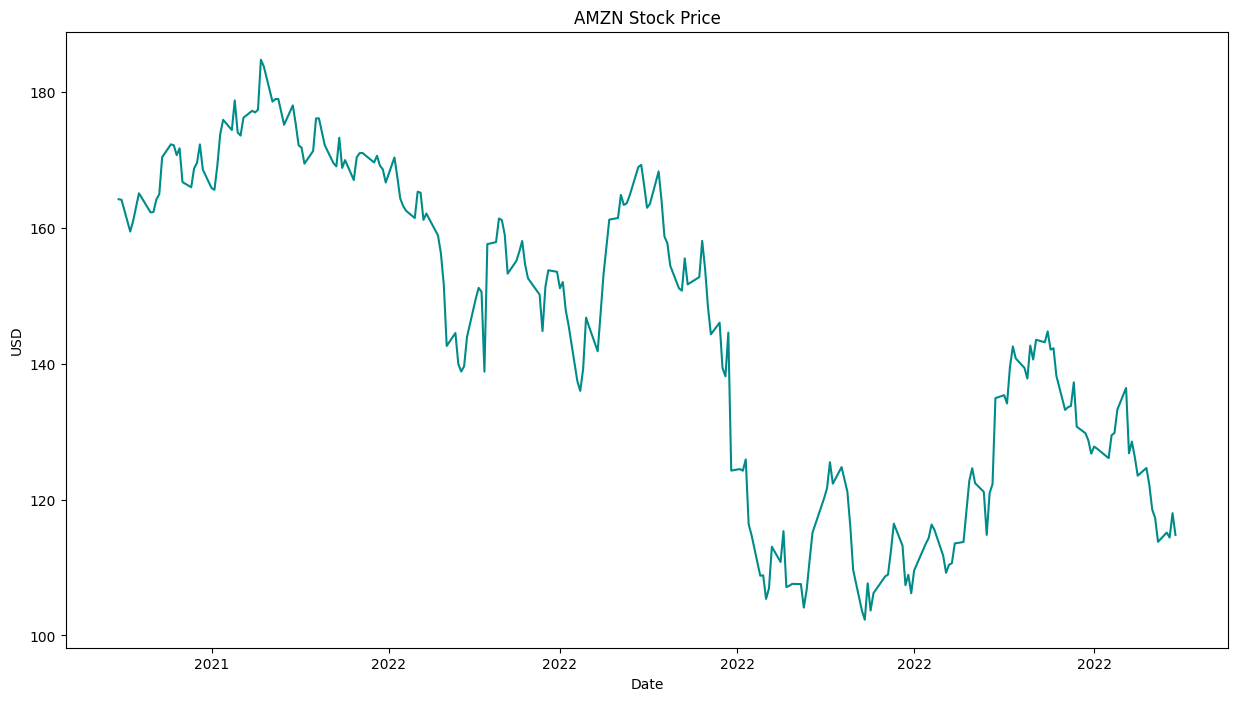

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter  # Import DateFormatter

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

#Adding technical indicators
MA(7) stans for Moving Average for past 7 days, whereas MA(20) means Moving Average for past 20 days.

EMA is Exponential Moving average and we can calculate it as:

EMA_t = Pclose + (EMA_t-1 (100 - P))* Bollinger Bands are calculated as:

middle line: stdev(MA(20)) upper bound: MA(20) + 2stdev(MA(20)) lower bound: MA(20) - 2stdev(MA(20))

In [ ]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [ ]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,compound_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,170.104996,173.949997,169.300003,172.328506,172.328506,114174000,-0.001450,169.436571,166.614751,-0.644339,4.111286,174.837323,158.392179,171.261756,5.143583
1,2021-10-29,165.001007,168.740997,163.666000,168.621506,168.621506,129722000,0.140447,169.132071,166.837676,-0.040452,4.092180,175.022037,158.653316,169.501589,5.121708
2,2021-11-01,168.089996,168.792999,164.600998,165.905502,165.905502,72178000,0.369745,168.297071,167.158501,-0.243565,3.720357,174.599216,159.717786,167.104198,5.105373
3,2021-11-02,165.750504,166.556000,164.177505,165.637497,165.637497,52552000,0.336614,168.134214,167.387876,-0.088001,3.455945,174.299767,160.475986,166.126397,5.103746
4,2021-11-03,165.449997,169.746002,164.876007,169.199997,169.199997,67944000,0.260729,168.588715,167.692851,0.389213,3.324309,174.341469,161.044234,168.175464,5.125154


In [ ]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

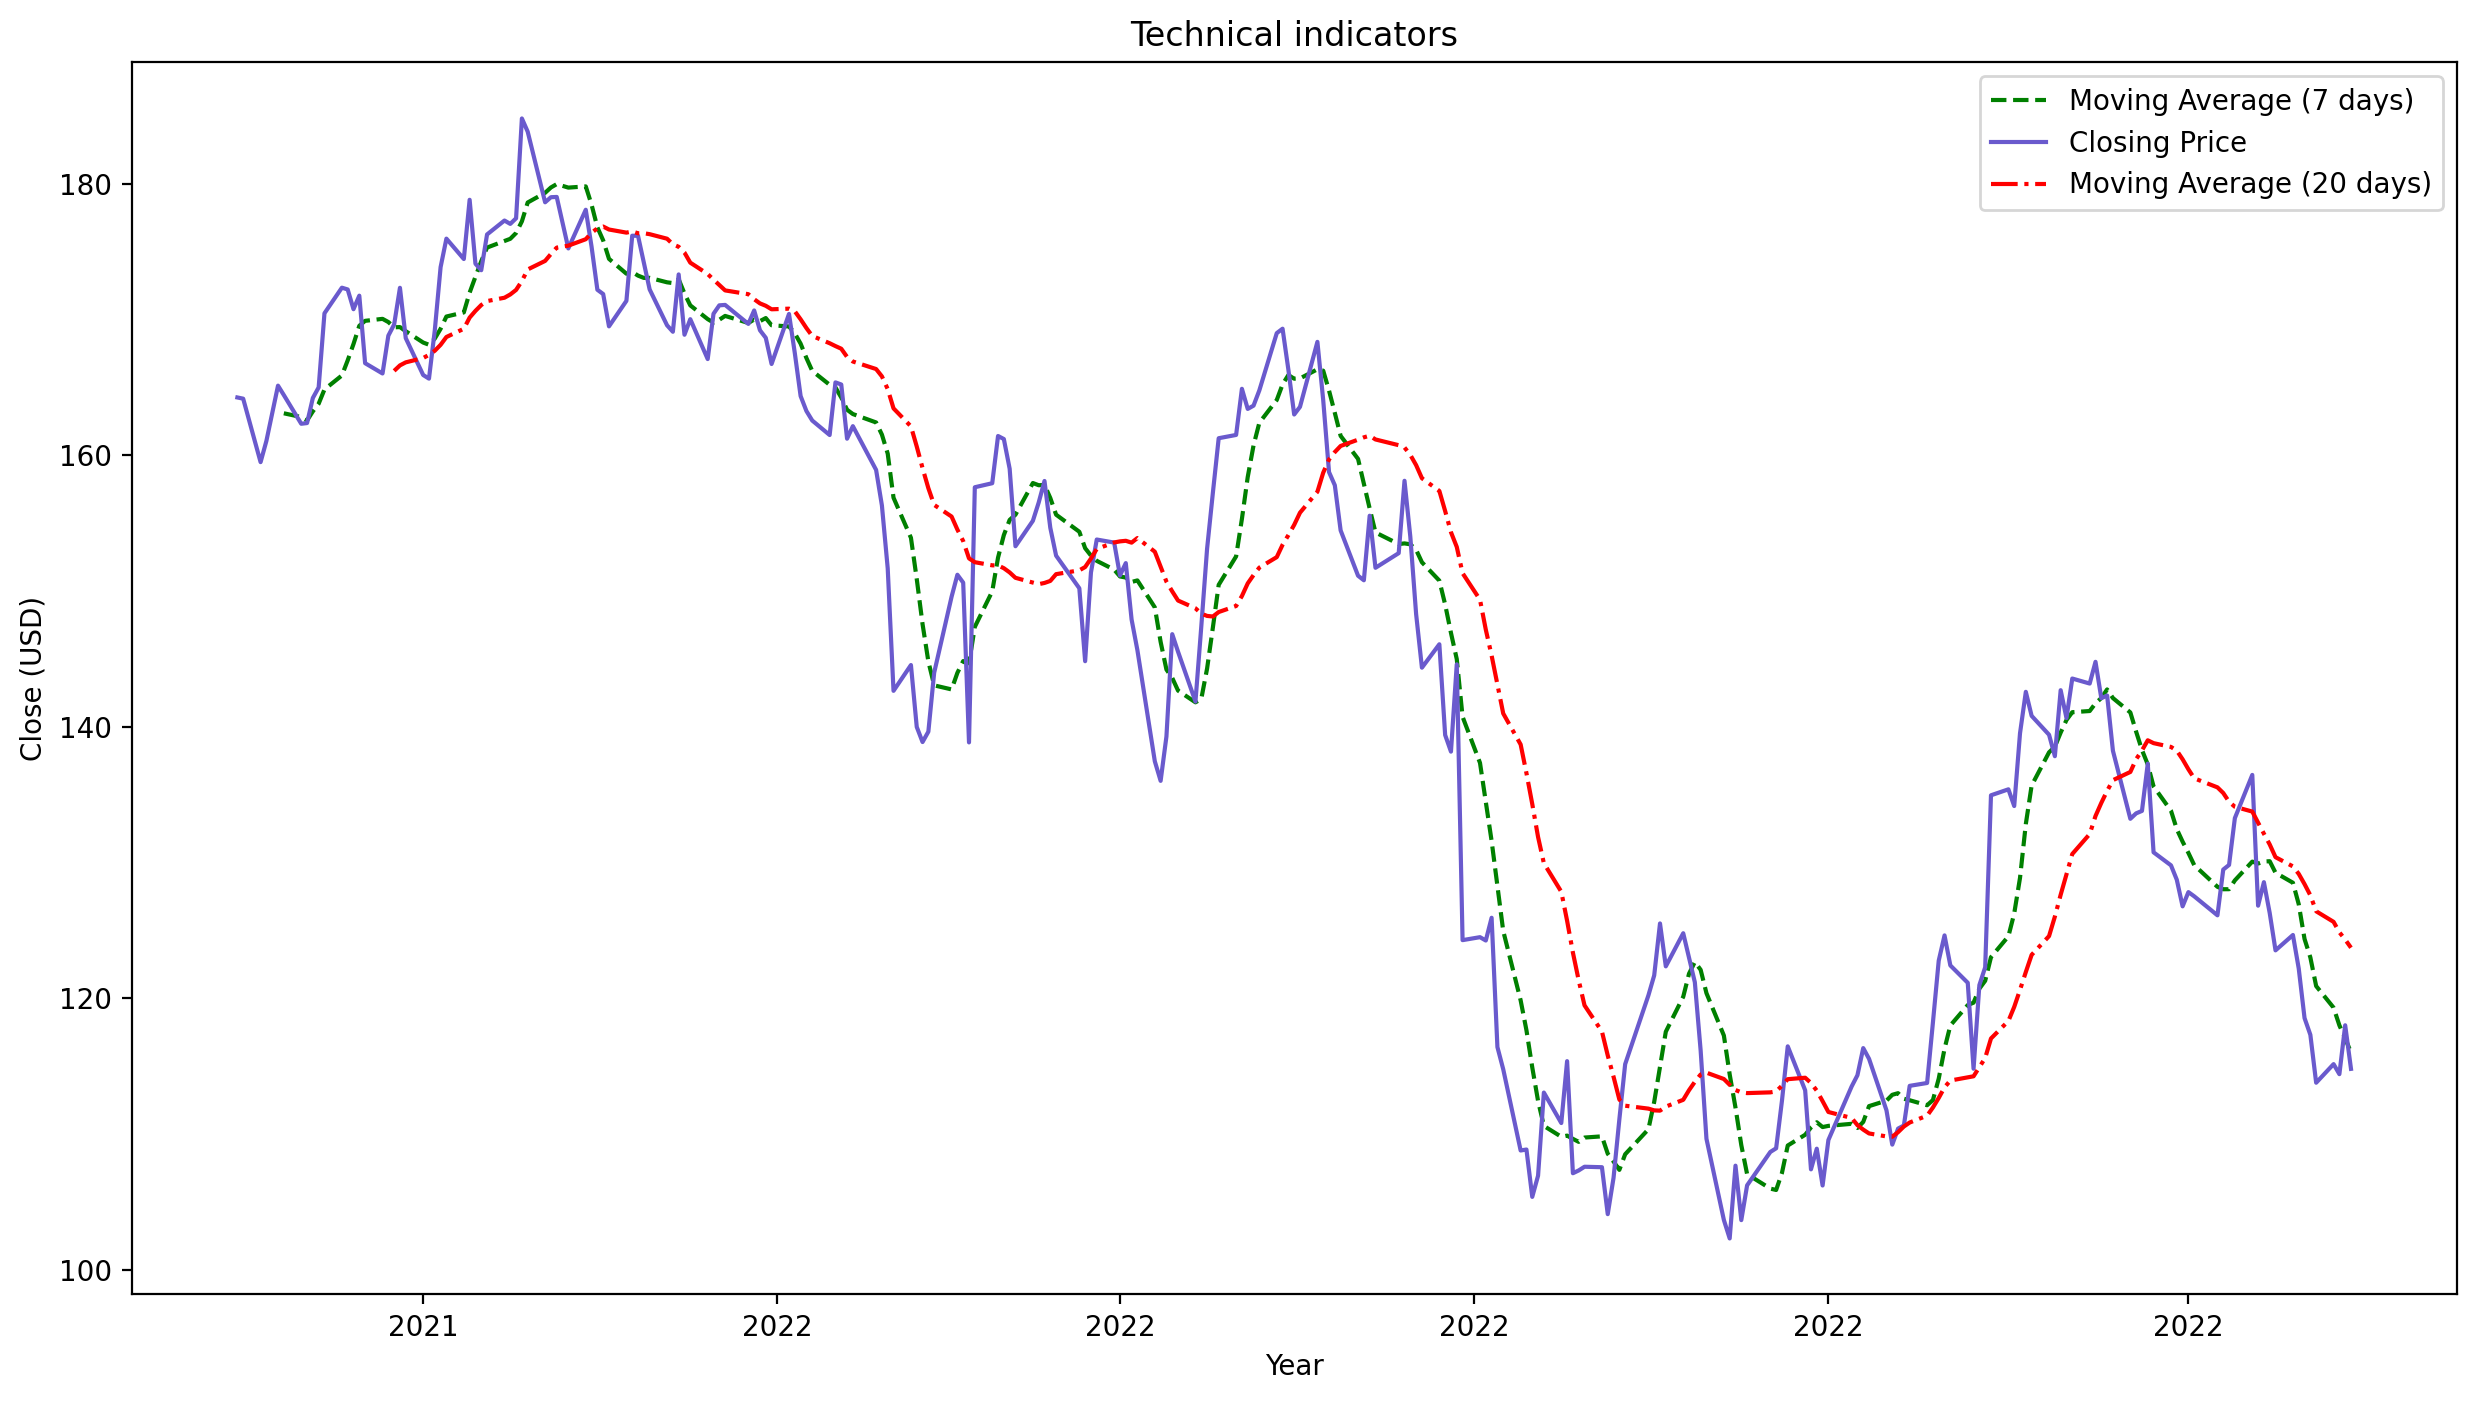

In [ ]:
tech_ind(tech_df)

In [ ]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [ ]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [ ]:
def normalize_data(df, range, target_column):

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [ ]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [ ]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pickle  # Import the pickle module

X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [ ]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [ ]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True,
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [ ]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [ ]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [ ]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [ ]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())


        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [ ]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [ ]:
## Test Code

@tf.function

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [ ]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

In [ ]:
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

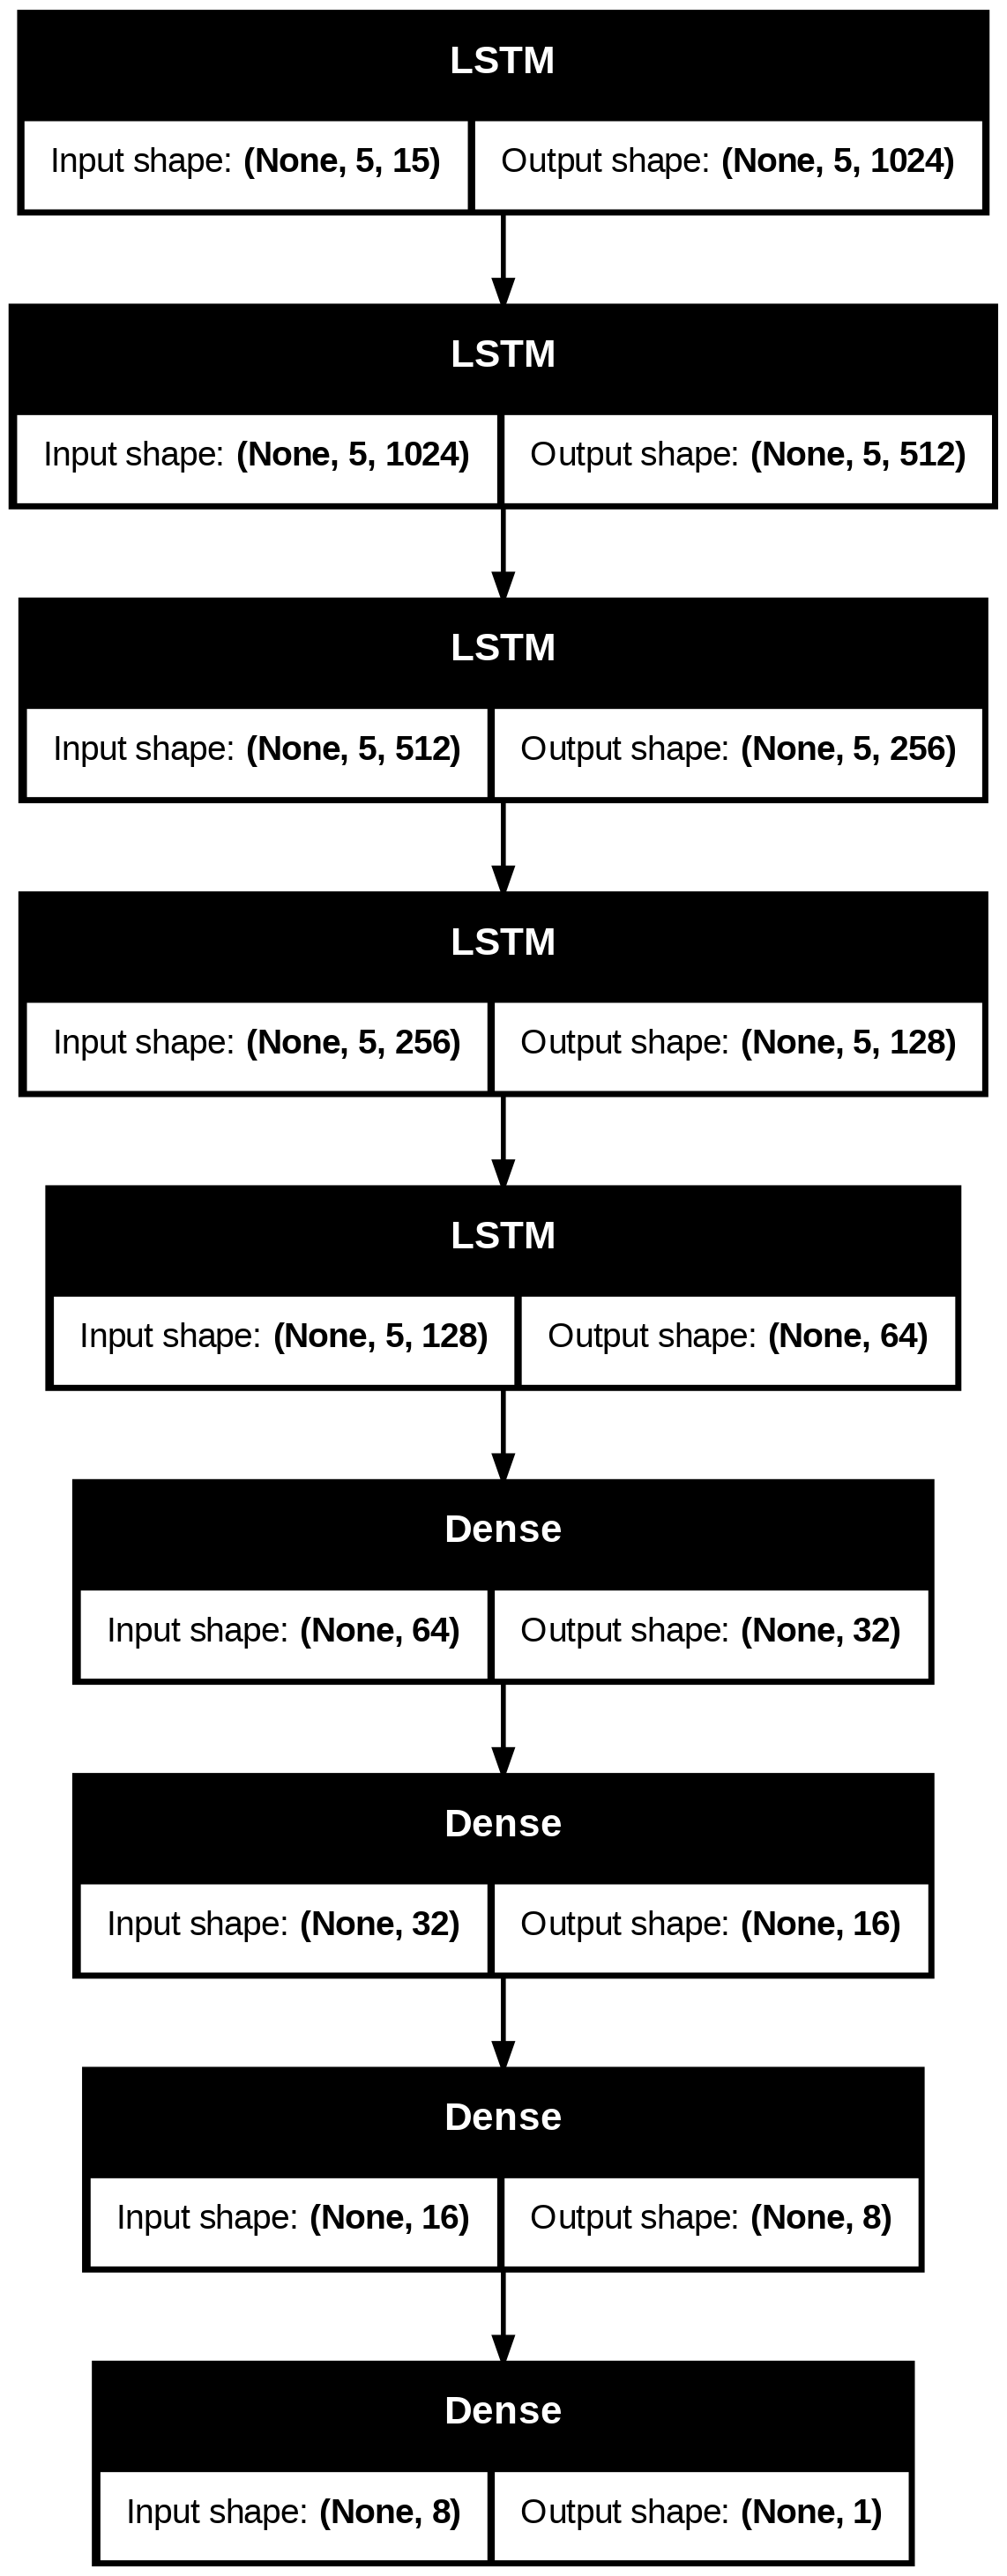

In [ ]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

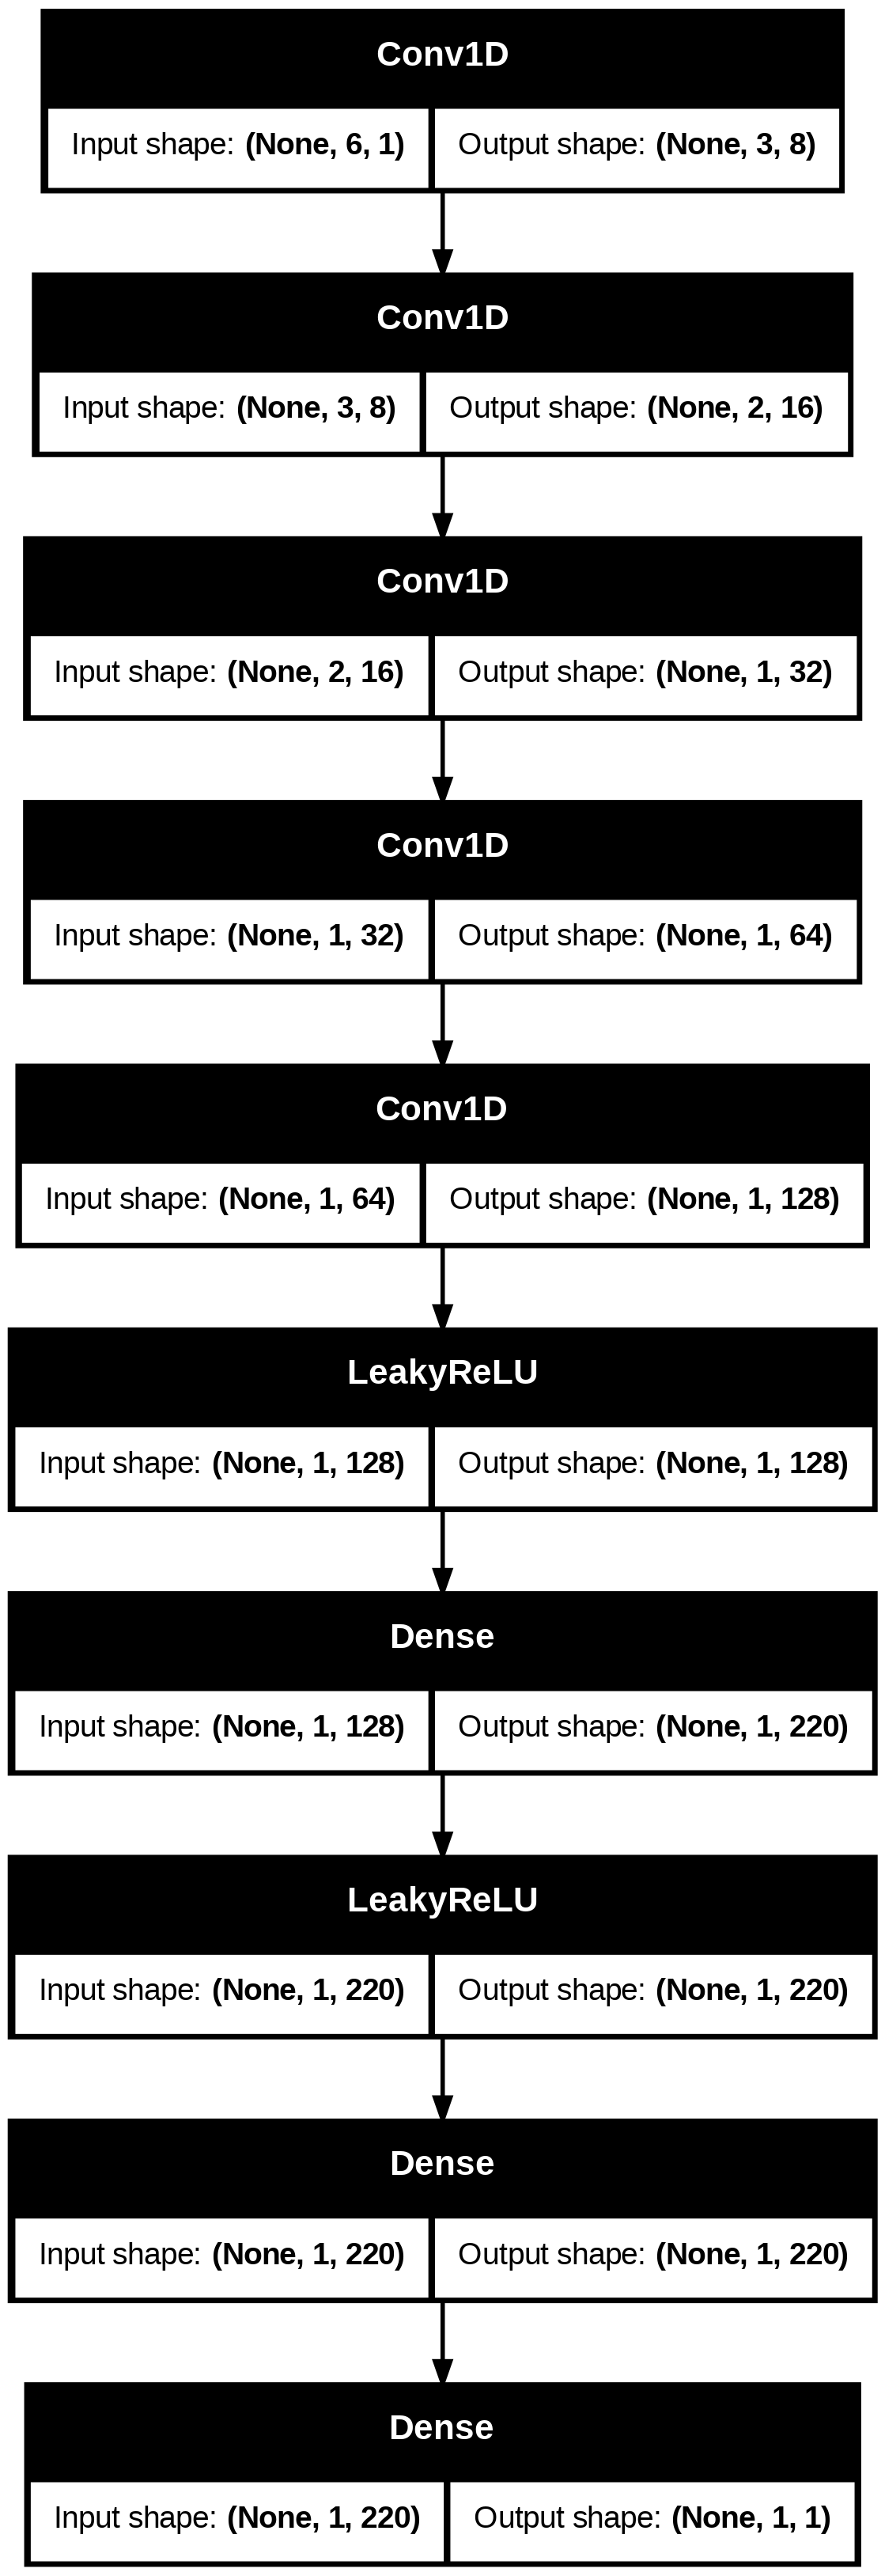

In [ ]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

 10%|█         | 50/500 [01:53<13:45,  1.83s/it]

epoch 50 discriminator_loss 1.3715146 generator_loss 0.6462277


 20%|██        | 100/500 [03:27<13:09,  1.97s/it]

epoch 100 discriminator_loss 1.3943202 generator_loss 0.6809242


 30%|███       | 150/500 [04:57<09:44,  1.67s/it]

epoch 150 discriminator_loss 1.3834298 generator_loss 0.69544953


 40%|████      | 200/500 [06:32<09:20,  1.87s/it]

epoch 200 discriminator_loss 1.3887244 generator_loss 0.6868464


 50%|█████     | 250/500 [08:07<09:06,  2.19s/it]

epoch 250 discriminator_loss 1.3864971 generator_loss 0.6980255


 60%|██████    | 300/500 [09:43<05:48,  1.74s/it]

epoch 300 discriminator_loss 1.3885243 generator_loss 0.6910762


 70%|███████   | 350/500 [11:21<05:31,  2.21s/it]

epoch 350 discriminator_loss 1.3856605 generator_loss 0.69591147


 80%|████████  | 400/500 [12:58<03:36,  2.16s/it]

epoch 400 discriminator_loss 1.3818992 generator_loss 0.6964569


 90%|█████████ | 450/500 [14:36<01:50,  2.20s/it]

epoch 450 discriminator_loss 1.3873823 generator_loss 0.68848103


100%|██████████| 500/500 [16:11<00:00,  1.94s/it]


epoch 500 discriminator_loss 1.3857367 generator_loss 0.6948947


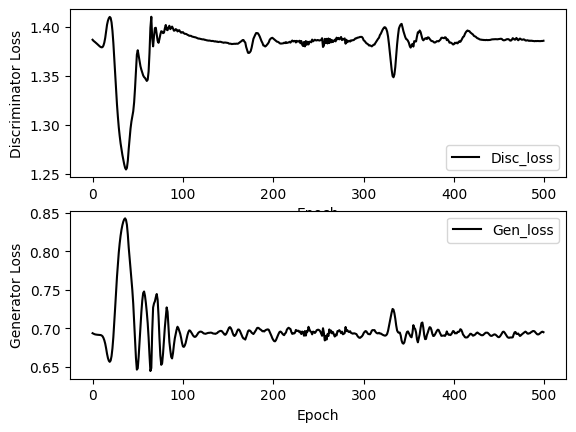

In [ ]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [ ]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

Test RMSE:  4.454438626933974


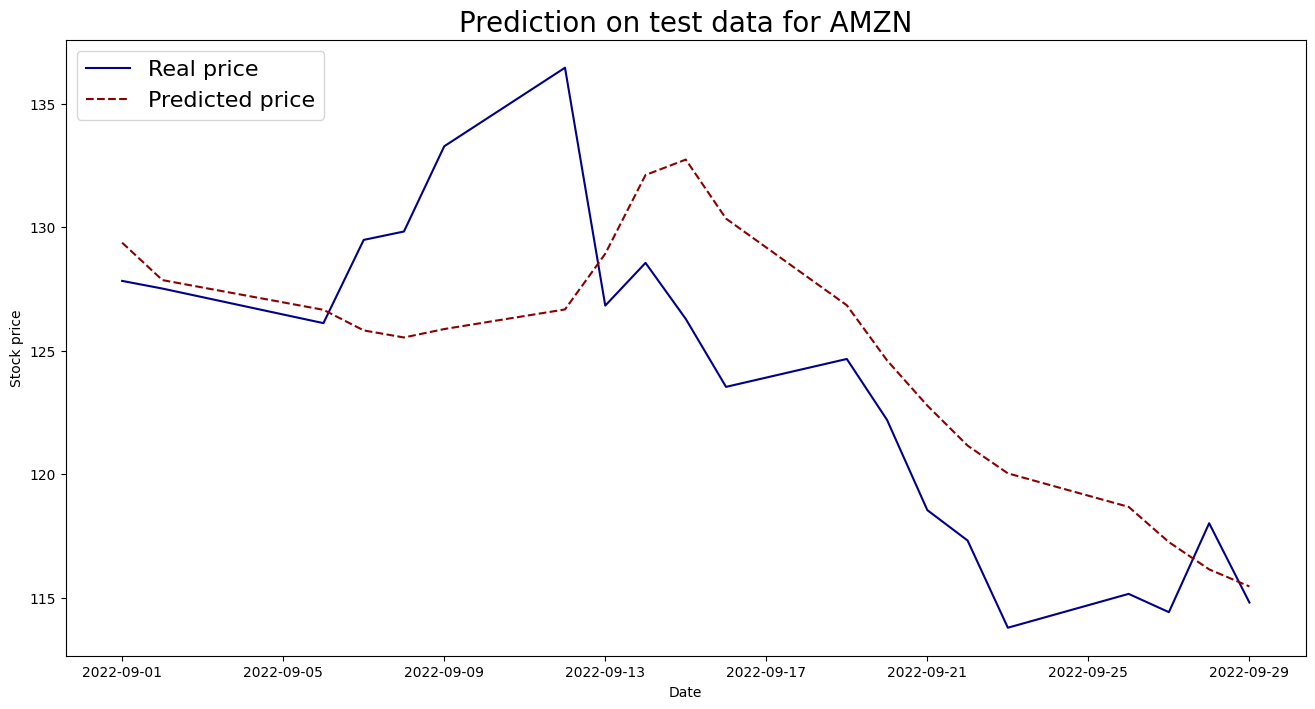

In [ ]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)